In [1]:
import torch.nn as nn
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import yaml
import gc

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

In [3]:
config_path = os.path.join(os.getcwd(), "config\config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)


In [4]:



class YOLO(nn.Module):
    def __init__(self, img_w = 448, img_h = 448, S = 7, B = 2, num_classes= 20):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.S = S
        self.B = B
        self.num_classes = num_classes

        self.pred_dim  =  self.B * 5 + self.num_classes


        ## mybackbone from figure 3 of the paper
        cnn_backbone_layers = [

            nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7,  stride = 2, padding =3),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 64, out_channels= 192,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(in_channels = 192, out_channels= 128,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 128, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 256, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 256, out_channels= 512,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ]

        for _ in range(4):
            cnn_backbone_layers.extend( 
                            [nn.Conv2d(in_channels = 512, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
                            self.conv_activations(),
                            nn.Conv2d(in_channels = 256, out_channels= 512,  kernel_size=3, stride = 1, padding =1),
                            self.conv_activations(),

                            ] )

        

        cnn_backbone_layers.extend(

            [
            nn.Conv2d(in_channels = 512, out_channels= 512,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 512, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            ]
        )


        for _ in range(2):
            cnn_backbone_layers.extend(
                
                [
                nn.Conv2d(in_channels = 1024, out_channels= 512,  kernel_size=1, stride = 1, padding =0),
                self.conv_activations(),
                nn.Conv2d(in_channels = 512, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                ]
            )

        cnn_backbone_layers.extend(
                
                [
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 2, padding =1),
                self.conv_activations(),
                ]
            )

        
        cnn_backbone_layers.extend(
                
                [
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                ]
            )                  
        self.backbone = nn.Sequential(*cnn_backbone_layers)


        #########Flatten, Feedforward Layers ####################

        self.mlp =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.S* self.S* 1024, 4096),
            self.conv_activations(),
            nn.Linear(4096, self.S*self.S* self.pred_dim),


        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.mlp(x)
        x = x.reshape(x.shape[0], self.S, self.S, self.pred_dim)
        return x
    
    def conv_activations(self):
        return nn.LeakyReLU(negative_slope=0.1)


In [ ]:
inp = torch.randn((4, 3, 448, 448))
model = YOLO()
model(inp).shape

How to Download Data

In [6]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="k7db5dkOnUu1oLFMzXvB")
# project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
# version = project.version(3)
# dataset = version.download("coco")

In [76]:
import json
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from collections import defaultdict
import torch
class MyObjectDetectionDataloader:

    def __init__(self, image_dir="..\Self-Driving-Car-3\export", annt_file = "..\Self-Driving-Car-3\export\_annotations.coco.json", train_transforms= None, img_w=512, img_h=512 ):

        self.train_transforms =  train_transforms
        self.image_dir = image_dir
        self.annt_file =  annt_file
        self.img_w   = 512
        self.img_h = 512
        self.model_img_w = 448
        self.model_img_h = 448
        self.scale_factor = self.model_img_w /self.img_w

        with open(self.annt_file , "r") as f:
            self.annot_data = json.loads(f.read())

        self.class_idx_to_name = {cat['id']: cat['name'] for i, cat in enumerate(self.annot_data["categories"])}
        self.image_id_to_labels = defaultdict(list)
        for annotation in self.annot_data["annotations"]:
            self.image_id_to_labels[annotation["image_id"]].append(annotation)
         


    def __getitem__(self, idx):
        image_name = self.annot_data["images"][idx]['file_name']
        image_id = self.annot_data["images"][idx]['id']

        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        if image.size!= (448, 448):
            image = image.resize((448, 448))

        labels = []
        boxes = []


        for item in self.image_id_to_labels[image_id]:
            x, y, w, h = item['bbox']  
            # boxes.append([  (x *self.scale_factor )/self.model_img_w, (y *self.scale_factor )/self.model_img_h, ((x + w) *self.scale_factor) /self.model_img_w,  ((y + h) *self.scale_factor)/self.model_img_h])
            boxes.append([  x, y, (x + w), (y + h)])
            
            labels.append([item['category_id']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.train_transforms:
            image = self.train_transforms(image)

        output_target  = {}
        output_target['boxes'] = boxes
        output_target['labels'] = labels

        return image, output_target


    def __len__(self):
        return len(self.annot_data["images"])
        pass
    
def collate_fn(batch):

    batch_image = torch.tensor([np.array(item[0]) for item in batch]) /255 ## if image is not normalized
    batch_image = batch_image.permute(0,3, 2, 1)
    targets = [item[1] for item in batch]
    return batch_image, targets


    # def __iter__(self):
    #     pass

    # def __next__(self):
    #     pass




In [78]:
train_data = MyObjectDetectionDataloader()
train_loader = DataLoader(dataset= train_data, batch_size=config["BATCH_SIZE"], collate_fn=collate_fn)
print("lentrain data",len(train_data))
for i in train_loader:
    print(i[0].shape)
    print(i[1][0], len(i[1]))

    break

lentrain data 29800
torch.Size([4, 3, 448, 448])
{'boxes': tensor([[140.0000, 262.0000, 161.0000, 287.5000],
        [266.0000, 231.0000, 290.0000, 326.5000],
        [271.0000, 241.0000, 288.0000, 317.0000],
        [280.0000, 220.0000, 369.5000, 341.0000]]), 'labels': tensor([[2],
        [2],
        [2],
        [2]])} 4


In [79]:
with open("..\Self-Driving-Car-3\export\_annotations.coco.json" , "r") as f:
    annot_data = json.loads(f.read())

In [80]:
len(annot_data["images"])

29800

In [81]:
def cord_to_box(box):
    ##converts  a x1,y1,x2,y2 to (center, h,w)

    x_center =  (box[:, 0] + box[:, 2])/2
    y_center =  (box[:, 1] + box[:, 3])/2
    
    w =  (box[:, 2] - box[:, 0])/2
    h =  (box[:, 3] - box[:, 1])/2


    return torch.stack([x_center, y_center, w, h], dim = 1)

def box_to_cord(box, indices, img_w_h):

    indices = indices.unsqueeze(1)
    box[:, :, :2 ] = box[:, :, :2 ] * (indices+1)  * (img_w_h)
    box[:, :, 2: ] = box[:, :, 2: ] * (img_w_h)
    box[:, :, :2 ]  = box[:, :, :2 ] - box[:, :, 2: ]/2  ## center to top_lhs
    box[:, :, 2: ]  = box[:, :, :2 ] + box[:, :, 2: ]/2  ## center to bottom_rhs
    
    return box


def compute_iou(boxesA, boxesB, epilson = 1e-6):
    # Add an extra dimension to boxesB for broadcasting
    boxesB = boxesB.unsqueeze(1)
    
    # Compute intersection coordinates
    top_lhs = torch.max(boxesA[..., :2], boxesB[..., :2])  # [B, N, M, 2]
    bottom_rhs = torch.min(boxesA[..., 2:], boxesB[..., 2:])  # [B, N, M, 2]
    
    # Calculate intersection area (corrected subtraction order)
    inter_width = torch.clamp(bottom_rhs[..., 0] - top_lhs[..., 0], min=0)
    inter_height = torch.clamp(bottom_rhs[..., 1] - top_lhs[..., 1], min=0)
    inter_area = inter_width * inter_height
    
    # Compute areas of boxesA and boxesB
    area_A = (boxesA[..., 2] - boxesA[..., 0]) * (boxesA[..., 3] - boxesA[..., 1])
    area_B = (boxesB[..., 2] - boxesB[..., 0]) * (boxesB[..., 3] - boxesB[..., 1])
    
    # Calculate union and IoU
    union = area_A + area_B - inter_area
    iou = inter_area / (union + epilson)  # Add epsilon to avoid division by zero
    return iou

Visualize Data

(448, 448, 3) uint8
(448, 448, 3) uint8
(448, 448, 3) uint8
(448, 448, 3) uint8


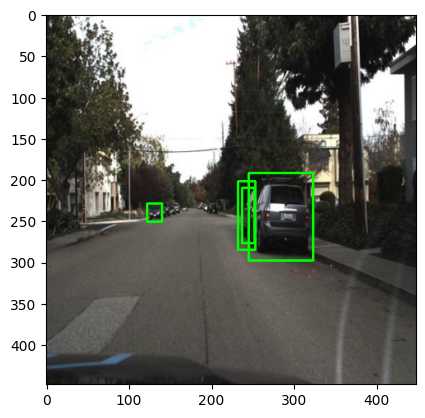

In [82]:
for i, (images, targets) in enumerate(train_loader):
    scale = 448/512
    for image, target in zip(images, targets):
        image = (image.permute(2,1,0).numpy()*255).astype('uint8')
        for (x1, y1, x2, y2) in target['boxes']:
            print(image.shape, image.dtype)
            # x1, y1, x2, y2 = int(x1*448),int(y1*448), int(x2*448), int(y2*448)
            x1, y1, x2, y2 = int(x1*scale),int(y1*scale), int(x2*scale), int(y2*scale)

            cv2.rectangle(image, (x1, y1), (x2, y2),  (0, 255, 0), thickness=2)
            plt.imshow(image )
            # break
    
        break
    break


In [83]:
#check model size
def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6
model = YOLO()
para = num_parameters(model)
print("#"*10)
print(f"Model Trainable Parameters:\n {para}")
print("#"*10)

##########
Model Trainable Parameters:
 271.441406
##########


Forward Pass Test

In [84]:
model = YOLO()
for i in train_loader:
    batch_image = i[0]
    print(batch_image.shape)

    outputs = model(batch_image)
    print(outputs.shape)

    break

torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 30])


##loss computation as per paper

Making the model's prediction with respect to each grid cell seems to help it atleast localize the object to be within that grid 

Else it will be penalized very heavily.

In [85]:
def yolo_weighted_sum_square_loss(predictions, targets, lambda_cord = 5, lambda_no_obj = 0.5,  S = 7, num_classes = 20, B = 2, grid_number =64 , scale_factor  = 448/512, model_img_h_w = 448 ):


    
    
    class_predictions = torch.softmax(predictions[:,:, :,  :num_classes  ],dim=-1)
    box_predictions = torch.sigmoid(predictions[:,:, :,  num_classes:  ] )
    box_predictions = box_predictions.reshape((predictions.shape[0], S, S, B, 5))
    box_confidences  =  box_predictions[:, :, :, :, -1]
    box_predictions  =  box_predictions[:, :, :, :, :4]

    box_center_predictions= box_predictions[:, :, :,:, :2]


    box_w_h_preds = box_predictions[:, :, :,:, 2:]
    # box_grid_locations = (box_predictions[:, :, :, :2] % S) +1
    # box_center_predictions= box_predictions[:, :, :, :2]/box_grid_locations  ## normalize box predictions by grid cordinates
    box_cord_center_loss =  0
    box_w_h_loss = 0
    class_confidence_loss = 0
    box_present_loss =0 
    no_box_present_loss = 0
    avg_ious = 0
    for batch in range(len(targets)):
        if len(targets[batch]['boxes']) > 0:

          ## load each predictions for each batch truth
          box_center_prediction = box_center_predictions[batch]
          box_w_h_pred = box_w_h_preds[batch]
          # ious = compute_iou(predictions[batch],  )
          class_prediction = class_predictions[batch]
          box_confidence = box_confidences[batch]


          ## box confidence loss
          ground_truth_boxes_orig = targets[batch]['boxes'].to(DEVICE) * scale_factor
          ground_truth_boxes = cord_to_box(ground_truth_boxes_orig)
          ground_truth_boxes = ground_truth_boxes/model_img_h_w
          ground_truth_boxes_center = ground_truth_boxes[:, :2]
          indices = torch.floor(  ((ground_truth_boxes_center / 64))).to(torch.long).to(DEVICE)
          box_center_prediction = box_center_prediction[indices[:,0],indices[:,1] ]
          
          box_cords = box_to_cord(box_predictions[batch][indices[:,0],indices[:,1] ], indices, model_img_h_w)
          

          ious = compute_iou(box_cords, ground_truth_boxes_orig )
          ## find responsible box predictor
          responsible = torch.argmax(ious, dim=1)
          avg_ious += (ious[torch.arange(box_center_prediction.shape[0]), responsible]).mean()
          ## get predictor  
          box_center_prediction = box_center_prediction[torch.arange(box_center_prediction.shape[0]), responsible]
          
          ground_truth_boxes_center = ground_truth_boxes_center/ (indices+1)
          ground_truth_classes  = targets[batch]['labels'].to(DEVICE)
          box_cord_center_loss  += ((ground_truth_boxes_center - box_center_prediction) **2).sum()
          

          ## box height andwidth loss
          box_w_h_pred = box_w_h_pred[indices[:,0],indices[:,1] ]
          ## get predictor  
          box_w_h_pred = box_w_h_pred[torch.arange(box_center_prediction.shape[0]), responsible]
          ground_truth_w_h = ground_truth_boxes[:, 2:]/model_img_h_w
          box_w_h_loss  += ((torch.sqrt(ground_truth_w_h) - torch.sqrt(torch.abs(box_w_h_pred))) **2).sum()

          ## box  present loss
          box_present_confidence_predictions = box_confidence[indices[:,0],indices[:,1] ]
          ## get predictor 
          box_present_confidence_predictions = box_present_confidence_predictions[torch.arange(box_center_prediction.shape[0]), responsible]
          box_present_loss += ((box_present_confidence_predictions -  torch.ones_like(box_present_confidence_predictions) )**2).sum()

          ## box not present loss
          mask = torch.ones(box_confidence.shape, dtype=torch.bool)
          mask[indices[:,0], indices[:,1]] = False  # Mask out the selected ones
          other_items = box_confidence[mask]
          no_box_present_loss += (other_items**2).sum()

          ## class probabilities loss  
          box_pred_classes = class_prediction[indices[:,0],indices[:,1] ]
          ground_truth_expanded =  torch.zeros_like(box_pred_classes)
          ground_truth_expanded[:, ground_truth_classes] = 1.0
          class_confidence_loss +=  ((box_pred_classes -  ground_truth_expanded)**2).sum()

          ## 
    return ( box_present_loss +lambda_no_obj * no_box_present_loss + class_confidence_loss +  lambda_cord * (box_w_h_loss + box_cord_center_loss) )/len(targets[batch]), avg_ious/len(targets[batch])


test loss

In [86]:
model = YOLO().to(DEVICE)
for i in train_loader:
    batch_image, targets = i
    batch_image =batch_image.to(DEVICE)
    print(batch_image.shape)

    outputs = model(batch_image)
    print(outputs.shape)
    
    loss, avg_ious =  yolo_weighted_sum_square_loss(outputs,  targets=targets )
    print(loss, avg_ious)
    break

torch.Size([4, 3, 448, 448])
torch.Size([4, 7, 7, 30])
tensor(84.4030, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)


In [87]:
torch.max(torch.tensor([5,2]), torch.tensor([3,3]))

tensor([5, 3])

Train Loop

In [88]:
def train(model, dataloader, optimizer):

    model.train()


    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    num_correct = 0
    total_loss  = 0
    avg_ious  = 0

    for i, (batch_image, targets) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        batch_image = batch_image.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(batch_image)
            loss, ious =  yolo_weighted_sum_square_loss(outputs,  targets=targets )


        # num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())
        avg_ious      += float(ious.item())


        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            avg_ious        = "{:.04f}".format(float(avg_ious / (i + 1))),
            # num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    # acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return total_loss


In [89]:
def validation(model, dataloader):

    model.eval()


    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Val', ncols=5)
    num_correct = 0
    total_loss  = 0
    avg_ious = 0
    for i, (batch_image, targets) in enumerate(dataloader):



        batch_image = batch_image.to(DEVICE)

        with torch.inference_mode(): # This implements mixed precision. Thats it!
            outputs = model(batch_image)
            loss, ious =  yolo_weighted_sum_square_loss(outputs,  targets=targets )


        total_loss      += float(loss.item())
        avg_ious      += float(ious.item())

        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            avg_ious        = "{:.04f}".format(float(avg_ious / (i + 1))),

            # num_correct = num_correct,
        )

        batch_bar.update() 

    batch_bar.close() 


    total_loss  = float(total_loss / len(dataloader))

    return total_loss

In [90]:
scaler = torch.cuda.amp.GradScaler()
model = YOLO().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr= config['LR'])

In [91]:
torch.cuda.empty_cache()
gc.collect() # These commands help you when you face CUDA OOM error


# for epoch in range(config['epochs']):
for epoch in range(1, config['EPOCHS']+1):
    
    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss = train(model, train_loader, optimizer) 
    print("Epoch {}/{} \n\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['EPOCHS'], train_loss, curr_lr))
    # val_loss = validation(model, train_loader)
    # print("Epoch {}/{} \n\t Val Loss {:.04f}\t Learning Rate {:.04f}".format(
    #     epoch + 1, config['EPOCHS'], train_loss, curr_lr))

Train:   0%|          | 9/7450 [01:07<19:53:34,  9.62s/it, avg_ious=0.0226, loss=109.6509, lr=0.0001]

KeyboardInterrupt: 

In [ ]:
print("Epoch {}/{} \n\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['EPOCHS'], train_loss, curr_lr))

In [ ]:
import  math
math.floor(447/64)